# Modeling Antibiotic Responce Through Datamining in the MIMICIII Dataset
###Garrett Eickelberg with help from Kishore Anekalla, Yikuan Li, Dr. Yuan Luo, Dr. Nelson Sanchez-Pinto

the streamlined version of "rotation_cohort_generation" has lots of debugging, older code, and non-utilized code removed to allow for top to bottom running. 

the overarching contents of this notebook will be detailed in my googledoc labnotebook 
https://docs.google.com/document/d/1bJcv0ZUkjVhFga9ZOLMNV6pXR9jLEMQmPhLS93njrCc/edit#

In [1]:
#libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import psycopg2
import collections
import asyncio
import getpass
import re
from datetime import datetime as dt
import os,sys,re
import urllib3
import prettytable
from collections import Counter
import seaborn as sns
import random
from datetime import timedelta

from sklearn.externals.joblib import Memory
memory = Memory(cachedir='/tmp', verbose=0)
#@memory.cache above any def fxn.

%matplotlib inline
plt.style.use('ggplot')

from notebook.services.config import ConfigManager
cm = ConfigManager()
cm.update('livereveal', {
        'width': 1024,
        'height': 768,
        'scroll': True,
})

%load_ext autotime

/Users/geickelb1/anaconda/envs/rpy-env/lib/python3.6/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


#reserach question:
-Can we predict the 5/7 day ab course by 48 hours after culture/ab start for icu patients?

#cohort criteria:
- YES- only adult patients (over 18 yo)  (~n= 38,000 age >18)
- with sterile culture 
- and ab start within the same 24 hours time window (bulk will be in first 24 hours but possibly not). 


Three subsets:
– Started on antibiotics, after 48hrs, negculture, discontinue	: neg/stop
- 48hrs, negculture, but continue full course 7, 10, or 14 days: neg/continue
– Positive culture, continue full course.Predict whether kept on antibiotics:

    pos/continue
    
	Infected with positive culture
    
	Infected with negative culture (ie a false positive)
    
    
#components: data cleaning, model building

In [2]:
#code used to ping the postgres mimic server. 

conn = psycopg2.connect(dbname="mimic", user="student", host="luolabwkstn01.fsm.northwestern.edu", port="5432",
                        password=getpass.getpass(prompt='Password:'.format()))
cur=conn.cursor()

query_schema = 'SET search_path to ' + "mimiciii" + ';'

time: 2.28 s


# importing prescription table annotated with RXCUI and ATC codes to id AB

In [ ]:
#some rows in AB have the same drug name, but differing true/false ab status. this is updating any antibiotic row as true.

#input: imported prescription df annotated with atc codes. 
#ouput: updated prescription df where more true antibiotics are covered

@memory.cache
def prescription_update_fxn(prescription_df):
        drugs_that_dont_belong =['Furosemide','Dextrose 50%','Vancomycin Oral Liquid',
                         'Erythromycin 0.5% Ophth Oint','NEO*IV*Furosemide',
                         'Nystatin','Orthopedic Solution','Neomycin-Polymyxin-Bacitracin Ophth. Oint',
                         'Bacitracin Ophthalmic Oint','Bacitracin Ointment','Lasix',
                         'dextrose','MetronidAZOLE Topical 1 % Gel','Enalaprilat',
                         'NEO*PO*Furosemide (10mg/1ml)','Metronidazole Gel 0.75%-Vaginal','Spironolactone',
                         'Heparin',
                        'voriconazole','valgancyclovir','chloroquine','tamiflu','mefloquine','foscarnet',
                         'fluconazole','vorconazole','quinine','ribavirin','gancyclovir','chloroquine',
                         'atovaquone','ambisome', 'acyclovir', 'Acyclovir']

    drugs_that_dont_belong=[w.lower() for w in drugs_that_dont_belong]
    
    prescriptions= prescription_df
    prescriptions_updated = list(prescriptions.loc[prescriptions.loc[:,"Antibiotics"]==True,'drug'].unique()) 
    true_ndc= prescriptions.loc[prescriptions.loc[:,"drug"].isin(prescriptions_updated),'ndc'].unique() 

    ABrx2= prescriptions.loc[prescriptions.loc[:,"ndc"].isin(true_ndc),:]
    ABrx2= ABrx2.loc[~ABrx2.loc[:,"drug"].str.lower().isin(drugs_that_dont_belong),:] #tilde transforms isin to notin()
    ABrx2['Antibiotics']= True
    return(ABrx2)



In [20]:
#note shown: imported antibiotic annotations into prescription table using code provided by
#Dr. Luo's postdoc, which pings API
dtype = {'icustay_id': str,
         'NDC': str,
         'rxcui': str,
         'ingredient': str}
prescriptions = pd.read_csv('/Users/geickelb1/Desktop/PhD_Misc/HSIP_442_Yuan_Lao/project/Newprescription.csv', index_col=0, dtype=dtype)

#problem: some rows in AB have the same drug name, but differing true/false ab status. this is updating any antibiotic row as true.


ABrx = prescription_update_fxn(prescriptions)
ABrx = ABrx.loc[ABrx['Antibiotics'] == True, :]
pd.DataFrame(ABrx).to_csv('/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-modeling/data/raw/csv/02082018_ABrx_updated.csv')


/Users/geickelb1/anaconda/envs/rpy-env/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning: Persisting input arguments took 1.54s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.


time: 6min 45s


In [3]:
ABrx = pd.read_csv('/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-modeling/data/raw/csv/02082018_ABrx_updated.csv')



time: 860 ms


In [4]:
len(ABrx) #156598

230069

time: 3.29 ms


In [23]:
ABrx['drug'].unique()

array(['Daptomycin', 'Ceftazidime', 'Vancomycin HCl',
       'Sulfameth/Trimethoprim SS', 'NEO*IV*Gentamicin', 'Cefepime',
       'Gentamicin Sulfate', 'Vancomycin', 'Levofloxacin',
       'Bacitracin/Polymyxin B Sulfate Opht. Oint', 'CefTRIAXone',
       'Sulfameth/Trimethoprim DS', 'Ciprofloxacin HCl', 'Metronidazole',
       'Azithromycin ', 'Cefazolin', 'Ceftriaxone', 'Imipenem-Cilastatin',
       'CeftazIDIME', 'CeftriaXONE', 'Clindamycin',
       'Piperacillin-Tazobactam Na', 'Ampicillin Sodium', 'CefazoLIN',
       'Cephalexin', 'Linezolid', 'Ampicillin', 'Ciprofloxacin IV',
       'MetRONIDAZOLE (FLagyl)', 'Nystatin Oral Susp.',
       'Nystatin Oral Suspension', 'Amoxicillin-Clavulanic Acid',
       'Ciprofloxacin 0.3% Ophth Soln', 'Unasyn',
       'Gentamicin Sulfate Ophth.', 'NEO*IV*AMPicillin Sodium',
       'NEO*IV*Ampicillin Sodium', 'Gentamicin', 'Azithromycin',
       'Aztreonam', 'Meropenem', 'NEO*IV*Vancomycin', 'Ciprofloxacin',
       'CefePIME', 'Piperacillin-Tazoba

time: 16.6 ms


# generating patient culture/icu/hospital info


## sterile culture info

In [4]:
#retrieving all patients with sterile culture

##changed on 4/16/18 to include all hadm_id
sterile_pt_sql = query_schema + """
SELECT row_id, subject_id, hadm_id, chartdate, charttime, spec_itemid, spec_type_desc, org_name FROM mimiciii.microbiologyevents
WHERE NOT lower(spec_type_desc) = 'fluid received in blood culture bottles' AND
NOT lower(spec_type_desc) = 'blood bag fluid'
AND (lower(spec_type_desc) LIKE '%blood%' 
OR lower(spec_type_desc) LIKE '%joint%' 
OR lower(spec_type_desc) LIKE '%urine%' 
OR lower(spec_type_desc) LIKE  '%csf%'
OR lower(spec_type_desc) LIKE '%spinal%'
OR lower(spec_type_desc) LIKE '%pleural%'
OR lower(spec_type_desc) LIKE '%peritoneal%')
group by subject_id, row_id
ORDER BY count(subject_id) DESC
"""

sterile_pt_df=pd.read_sql_query(sterile_pt_sql,conn) #33900 patients with sterile culture


time: 13.7 s


In [5]:
#a more detailed patient/admission/age data query

pt_age_admin_sql = query_schema + """
select p.subject_id, c.hadm_id, c.admittime, c.dischtime, c.admission_location, c.admission_type, p.first_admit_age, p.dob, p.gender from mimiciii.admissions c
join (SELECT
      p.subject_id, p.dob, p.gender, MIN( ROUND( (cast(admittime as date) - cast(dob as date)) / 365.242,2) )
          AS first_admit_age
  FROM mimiciii.patients p
  INNER JOIN mimiciii.admissions a
  ON p.subject_id = a.subject_id
  GROUP BY p.subject_id, p.dob, p.gender
  ORDER BY p.subject_id) p on c.subject_id = p.subject_id
"""
pt_age_admin_df = pd.read_sql_query(pt_age_admin_sql,conn) #38637
pt_age_admin_16_df= pt_age_admin_df.loc[pt_age_admin_df.loc[:,'first_admit_age']>16,:]
pt_age_admin_16_df = pt_age_admin_16_df.rename(index=str, columns={"admittime":'hosp_admit','dischtime':'hosp_disch'})

pt_source_sql = query_schema + """
SELECT subject_id, icustay_id, hadm_id, dbsource, intime, outtime, los, FIRST_WARDID, LAST_WARDID from mimiciii.icustays
"""
pt_source_df =pd.read_sql_query(pt_source_sql,conn) #46520 patients total, no ab, culture or age restrict
pt_source_df = pt_source_df.rename(index=str, columns={"intime":'ICU_admit','outtime':'ICU_disch'})

#merging icu info with patient admiin info- has all icustay id's with patient and admission info.
pt_icu_hosp_db_16 =pd.merge(pt_age_admin_16_df,pt_source_df.drop(['subject_id'], axis=1), left_on= 'hadm_id', right_on='hadm_id', how = 'right')
# len(pt_source_df) #61532
# len(pt_age_admin_16_df)#50857
# len(pt_icu_hosp_db_16) #61532



time: 7.75 s


### - mergeing sterile_pt_df with pt_icu_hosp_db_16
    filtering and merging patient/hospital/icu admin data for pt>16 yo, with all sterile culture pt.
    final df- ptinfo_ICUsterile_16:
    is all the hospital, icu admission, and patient data for patients >=16yo



In [6]:
#1merge sterile_pt_df with pt_icu_hosp_db_16

#notes: we want to to include sterile cultures inside and outside of ICU. 

sterile_all_pt_info= None
sterile_all_pt_info = pd.merge(pt_icu_hosp_db_16, sterile_pt_df.drop(['subject_id'], axis=1), left_on= 'hadm_id', right_on='hadm_id', how = 'inner')
#filtering and merging patient/hospital/icu admin data for pt>16 yo, with all sterile culture pt.

sterile_all_pt_info.loc[sterile_all_pt_info.loc[:,'charttime'].isnull(),'charttime'] = sterile_all_pt_info.loc[sterile_all_pt_info.loc[:,'charttime'].isnull(),'chartdate']
#making all sterile culture charttime null rows = to chartdate. 

len(sterile_all_pt_info) #438662 rows
len(sterile_all_pt_info['hadm_id'].unique()) #41655 
len(sterile_all_pt_info['icustay_id'].unique())# 45126

###removed below lines because we want to include sterile cultures outside of ICU. 
#annotates the sterile cultures and returns True if it's within the icu time window.
##sterile_all_pt_info['sterile_dur_icu']= (sterile_all_pt_info['ICU_disch'] >= sterile_all_pt_info['charttime']) &(sterile_all_pt_info['charttime']>=sterile_all_pt_info['ICU_admit'])
#sterile_all_pt_info_icu= sterile_all_pt_info.loc[sterile_all_pt_info.loc[:,'sterile_dur_icu']==True,:]

###master#### 
#this is all the hospital, icu admission, and patient data for patients >=16yo, 
#with a sterile culture associated with hadm_id that occured during icu timewindow.
#note due to removing icu restriction, the ptinfo_ICUsterile_16 and sterile_all_pt_info are the same  because i filtered on 16yo earlier.
#i kept it this way for ease of naming convention. may clean up at a later date.
ptinfo_ICUsterile_16=0
ptinfo_ICUsterile_16= sterile_all_pt_info.loc[sterile_all_pt_info.loc[:,'first_admit_age']>=16,:] #changed from sterile_all_pt_info_icu
###master####
ptinfo_ICUsterile_16=ptinfo_ICUsterile_16.rename(index=str, columns={'charttime':'culture_charttime'})


time: 1.02 s


# building patient list from PRESCRIPTION table

In [7]:
#2
#set(list(ABrx_ntnull)).intersection(set(list(sterile_all_pt_info))) #hadm, icustay_id, subject_id, row_id

ptinfo_ICUsterile_16_pt= ptinfo_ICUsterile_16.drop_duplicates('icustay_id')#25054
ABrx_ntnull= ABrx.loc[ABrx.loc[:,"icustay_id"].notnull(),:]
ABrx_16sterile_ntnul = 0
#have to convert icustay_id's to numbers to merge
ptinfo_ICUsterile_16_pt['icustay_id']= pd.to_numeric(ptinfo_ICUsterile_16_pt['icustay_id'])
ABrx_ntnull['icustay_id']= pd.to_numeric(ABrx_ntnull['icustay_id'])
ABrx_16sterile_ntnul= pd.merge(ABrx_ntnull, ptinfo_ICUsterile_16_pt.drop(['icustay_id','hadm_id','row_id'], axis=1), left_on= 'subject_id', right_on='subject_id', how = 'inner')



#added on 4/24/18: there are some erronious rows where start date > enddate. these are being removed. 
keep_criteria1 = pd.to_datetime(ABrx_16sterile_ntnul['startdate']) <= pd.to_datetime(ABrx_16sterile_ntnul['enddate'])

ABrx_16sterile_ntnul= ABrx_16sterile_ntnul[keep_criteria1]

print(len(ABrx_16sterile_ntnul), #2521764 rows -> 111796  -> 132083 ->130646 after remove criteria
len(ABrx_16sterile_ntnul['hadm_id'].unique()), #26701  -> 17898  -> 24282
len(ABrx_16sterile_ntnul['icustay_id'].unique()), # 28429 ->18778 -> 26009
len(ABrx_16sterile_ntnul['subject_id'].unique()))# 22035 -> 14903 -> 19638   #final set is after readding back the sterile culture outside of icu stay. 
#->19790 after remove criteria



/Users/geickelb1/anaconda/envs/rpy-env/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/geickelb1/anaconda/envs/rpy-env/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


304126 25217 26952 19790
time: 1.09 s


Populating the interactive namespace from numpy and matplotlib


/Users/geickelb1/anaconda/envs/rpy-env/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['cm', 'random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


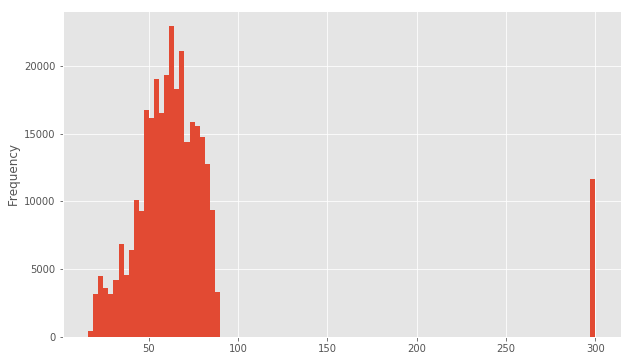

time: 322 ms


In [8]:
len(ABrx_ntnull['icustay_id'].unique())

%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6)
ABrx_16sterile_ntnul['first_admit_age'].sort_values(ascending=True).plot.hist(100)

In [9]:
# updated 4/11/18
#1- filter only on PRESCRIPTION rows that are in ICU
#2- ABrx sterile 16. 
#3- annotating the patients who have antibiotics data in cv, mv, or both. (pt_ab_db)
    #note this is different from dbsource, which is specific to the icustay_id
    
#annotating the patients who have antibiotics data in cv, mv, or both. 

cv_pts= ABrx_16sterile_ntnul[ABrx_16sterile_ntnul['dbsource']=='carevue']['subject_id'].unique()
mv_pts= ABrx_16sterile_ntnul[ABrx_16sterile_ntnul['dbsource']=='metavision']['subject_id'].unique()

both_pts= []
for pt in ABrx_16sterile_ntnul["subject_id"].unique():
    if pt in cv_pts and pt in mv_pts:
        both_pts.append(pt)
        
#need to annotate in pt_db_association column
ABrx_16sterile_ntnul.loc[ABrx_16sterile_ntnul.loc[:,'dbsource']=='carevue','pt_ab_db']='cv_ab' 
ABrx_16sterile_ntnul.loc[ABrx_16sterile_ntnul.loc[:,'dbsource']=='metavision','pt_ab_db']='mv_ab'
ABrx_16sterile_ntnul.loc[ABrx_16sterile_ntnul.loc[:,'dbsource']=='both','pt_ab_db']='both_marking_ab' 
ABrx_16sterile_ntnul.loc[ABrx_16sterile_ntnul.loc[:,'subject_id'].isin(both_pts),'pt_ab_db']='cv/mv_ab'


ABrx_16sterile_ntnul_pts = ABrx_16sterile_ntnul.sort_values('startdate').drop_duplicates('subject_id')
ABrx_16sterile_ntnul_pts = ABrx_16sterile_ntnul_pts[['subject_id','Antibiotics','dob','gender','first_admit_age','pt_ab_db']]
#pt_ab_age_df = pd.merge(pt_sterile16_list, ABrx_merged_16sterile_ntnul_pts[['subject_id','pt_ab_db']], left_on= 'subject_id', right_on='subject_id',how = 'inner') 

ABrx_16sterile_ntnul_pts['pt_ab_db'].value_counts() #total: 14903

#numbers before regenerating dataset (filtered for only culture dates within icu date windows -> pt has any sterile culture)
# cv_ab              10394 -> 9639 -> 9610
# mv_ab               9993 -> 9243 -> 9107
# cv/mv_ab             777 -> 684 -> 1006
# both_marking_ab       72 -> 72 -> 67
# Name: pt_ab_db, dtype: int64

cv_ab              9610
mv_ab              9107
cv/mv_ab           1006
both_marking_ab      67
Name: pt_ab_db, dtype: int64

time: 7 s


In [10]:
#4/24/18
#task 1: mark t0 and t_end for each patient. 
##t0 is the first ab date in icu associated within 24 hours of sterile site culture
##t_end is the longest duration ab associated with t0

lessthan24hr= abs(pd.to_datetime(ABrx_16sterile_ntnul['startdate']) - pd.to_datetime(
    ABrx_16sterile_ntnul['culture_charttime'])) <='24:00:00'


ABrx_16sterile_ntnul['ab_culture_delta'] = (
    pd.to_datetime(ABrx_16sterile_ntnul['startdate']) 
    - pd.to_datetime(ABrx_16sterile_ntnul['culture_charttime'])
)

ABrx_ab24hrdelta= ABrx_16sterile_ntnul.loc[lessthan24hr]

ABrx_ab24hrdelta['t_0']= ABrx_ab24hrdelta.groupby('icustay_id')['startdate'].transform(lambda x: min(x))

ABrx_16sterile_ptAB24startdate= ABrx_ab24hrdelta[['icustay_id','t_0']].drop_duplicates('icustay_id')

ABrx_16sterile_ptAB24enddate= ABrx_ab24hrdelta[
    ABrx_ab24hrdelta['startdate']==ABrx_ab24hrdelta[
        't_0']].sort_values(
            ['subject_id','icustay_id','enddate'], ascending=[True,True,False]).drop_duplicates('icustay_id')


#adding T_0 and T_end to ABrx_16sterile_ntnul
ABrx_16sterile_ntnul= (
    pd.merge(
        ABrx_16sterile_ntnul,
        ABrx_16sterile_ptAB24startdate,
        left_on= 'icustay_id', right_on='icustay_id', how = 'left')
)
ABrx_16sterile_ntnul= (
    pd.merge(
        ABrx_16sterile_ntnul,
        ABrx_16sterile_ptAB24enddate[['icustay_id','enddate']],
        left_on= 'icustay_id', right_on='icustay_id', how = 'left')
)
#renaming columns for ease
ABrx_16sterile_ntnul=(
    ABrx_16sterile_ntnul.rename(index=str, columns={'enddate_x':'enddate',"enddate_y":"t_end"})
)


#####
#task 2, refine ABrx_16sterile_ntnul to only ab's that are at or after t0.
#ABrx_16sterile_ntnul2 is only rows where the ab's are 
#at or after the first date where an ab is within 24 hour of culture.
 
ABrx_16sterile_ntnul2=(
    ABrx_16sterile_ntnul.loc[
        ABrx_16sterile_ntnul['startdate'] >= ABrx_16sterile_ntnul['t_0']]
)
ABrx_16sterile_ntnul2['t_end_consec']=ABrx_16sterile_ntnul2['t_end']
ABrx_16sterile_ntnul2['abduration']= (
    pd.to_datetime(ABrx_16sterile_ntnul2['enddate'])
    - pd.to_datetime(ABrx_16sterile_ntnul2['startdate'])
)

ABrx_16sterile_ntnul2.sort_values(['subject_id','startdate'])
#155775 rowsv this should be df where all ab_icustart dates are greater than or 
#equal to the first 24 hour associated ab start date after icu admission.


/Users/geickelb1/anaconda/envs/rpy-env/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/geickelb1/anaconda/envs/rpy-env/lib/python3.6/site-packages/ipykernel_launcher.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/geickelb1/anaconda/envs/rpy-env/lib/python3.6/site-packages/ipykernel_launcher.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

,Unnamed: 0,row_id,subject_id,hadm_id,icustay_id,startdate,enddate,drug_type,drug,drug_name_poe,...,culture_charttime,spec_itemid,spec_type_desc,org_name,pt_ab_db,ab_culture_delta,t_0,t_end,t_end_consec,abduration
167634,2440736,1213119,4,185777,294638.0,2191-03-18,2191-03-20,MAIN,Vancomycin HCl,NaN,...,2191-03-18 08:00:00,70012,BLOOD CULTURE,None,cv_ab,-1 days +16:00:00,2191-03-18,2191-03-20,2191-03-20,2 days
167629,2441160,2089134,9,150750,220597.0,2149-11-11,2149-11-15,MAIN,Levofloxacin,Levofloxacin,...,2149-11-11 12:00:00,70079,URINE,None,cv_ab,-1 days +12:00:00,2149-11-11,2149-11-15,2149-11-15,4 days
167630,2441172,2089868,9,150750,220597.0,2149-11-13,2149-11-15,MAIN,Vancomycin HCl,NaN,...,2149-11-11 12:00:00,70079,URINE,None,cv_ab,1 days 12:00:00,2149-11-11,2149-11-15,2149-11-15,2 days
167637,2440904,616190,12,112213,232669.0,2104-08-11,2104-08-11,MAIN,Metronidazole,NaN,...,2104-08-11 00:00:00,70079,URINE,None,cv_ab,0 days 00:00:00,2104-08-11,2104-08-12,2104-08-12,0 days
167638,2440907,616189,12,112213,232669.0,2104-08-11,2104-08-12,MAIN,Levofloxacin,NaN,...,2104-08-11 00:00:00,70079,URINE,None,cv_ab,0 days 00:00:00,2104-08-11,2104-08-12,2104-08-12,1 days
167639,2440915,616851,12,112213,232669.0,2104-08-12,2104-08-12,MAIN,Piperacillin-Tazobactam Na,NaN,...,2104-08-11 00:00:00,70079,URINE,None,cv_ab,1 days 00:00:00,2104-08-11,2104-08-12,2104-08-12,0 days
167640,2440918,616192,12,112213,232669.0,2104-08-12,2104-08-13,MAIN,Piperacillin-Tazobactam Na,NaN,...,2104-08-11 00:00:00,70079,URINE,None,cv_ab,1 days 00:00:00,2104-08-11,2104-08-12,2104-08-12,1 days
167641,2440919,616852,12,112213,232669.0,2104-08-12,2104-08-14,MAIN,Piperacillin-Tazobactam Na,NaN,...,2104-08-11 00:00:00,70079,URINE,None,cv_ab,1 days 00:00:00,2104-08-11,2104-08-12,2104-08-12,2 days
167642,2440930,616856,12,112213,232669.0,2104-08-14,2104-08-15,MAIN,Piperacillin-Tazobactam Na,NaN,...,2104-08-11 00:00:00,70079,URINE,None,cv_ab,3 days 00:00:00,2104-08-11,2104-08-12,2104-08-12,1 days
167672,2441527,2572274,19,109235,273430.0,2108-08-06,2108-08-08,MAIN,Levofloxacin,NaN,...,2108-08-05 20:42:00,70079,URINE,None,cv_ab,0 days 03:18:00,2108-08-06,2108-08-08,2108-08-08,2 days


time: 5.3 s


In [11]:
###Algorithm to squash all dates into a timespan that covers the continuous days on any AB starting at the first ab within 24 hour of a sc
@memory.cache
def update_t_end(t):  
    t.loc[
        ((pd.to_datetime(t['startdate']) <= pd.to_datetime(t['t_end_consec'])) & (
            pd.to_datetime(t['enddate']) >= pd.to_datetime(t['t_end_consec']))),'t_end_consec']= t.loc[
        ((pd.to_datetime(t['startdate']) <= pd.to_datetime(t['t_end_consec'])) & (
            pd.to_datetime(t['enddate']) >= pd.to_datetime(t['t_end_consec']))),'enddate']
    t['t_end_consec']= t.groupby('icustay_id')['t_end_consec'].transform(lambda x: max(x))
    t['abduration']= pd.to_datetime(t['t_end_consec'])-pd.to_datetime(t['t_0'])
    return(t)


time: 9.1 ms


In [12]:
##Calculate and annotate the total continuous time on ANY antibiotic during each patient’s icu stay
#ABrx_16sterile_ntnul3 is same as 2 but with fewer columns for easier handling
important_columns=['subject_id', 'icustay_id', 'drug','culture_charttime','ab_culture_delta','startdate','enddate','t_0','t_end','abduration','t_end_consec']

ABrx_16sterile_ntnul3= ABrx_16sterile_ntnul2[important_columns].sort_values(
    ['subject_id',
     'icustay_id',
     'startdate',
     'abduration'], ascending=[True, True, False, True])

n=ABrx_16sterile_ntnul3

i=1
while i<6:
    ABrx_16sterile_ntnul3= update_t_end(ABrx_16sterile_ntnul3)
    i+=1

time: 54.3 s


In [13]:
ABrx_16sterile_ntnul_finalPT= ABrx_16sterile_ntnul3.sort_values(['subject_id','startdate'], ascending=[True,True]).drop_duplicates('subject_id')


time: 93.6 ms


count                     12611
mean     4 days 20:23:30.197446
std      5 days 00:31:33.052373
min             0 days 00:00:00
25%             2 days 00:00:00
50%             3 days 00:00:00
75%             6 days 00:00:00
max            63 days 00:00:00
Name: abduration, dtype: object
1 days    1895
2 days    1890
3 days    1693
4 days    1241
5 days     992
0 days     964
6 days     857
7 days     669
Name: abduration, dtype: int64
(7 days 22:40:47.999999, 63 days 00:00:00]    2410
Name: abduration, dtype: int64


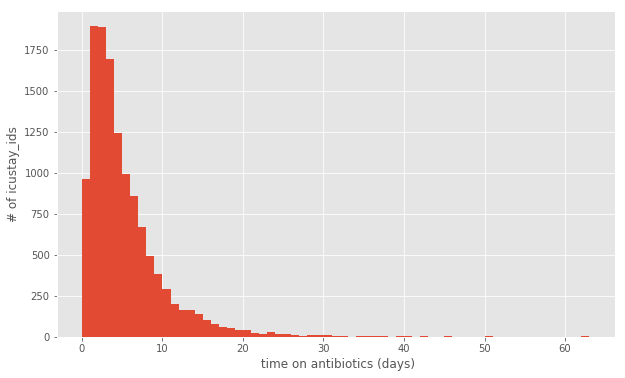

time: 249 ms


In [14]:
print(ABrx_16sterile_ntnul_finalPT['abduration'].describe())

(ABrx_16sterile_ntnul_finalPT['abduration'] / pd.Timedelta(days=1)).hist(bins = 63)#bins=xrange(min(compare_table['date delta']), 120, 1))
plt.xlabel(' time on antibiotics (days)')
plt.ylabel('# of icustay_ids');

print(ABrx_16sterile_ntnul_finalPT.loc[ABrx_16sterile_ntnul_finalPT.loc[:,'abduration']<= pd.Timedelta(days=7),'abduration'].value_counts())
print(ABrx_16sterile_ntnul_finalPT.loc[ABrx_16sterile_ntnul_finalPT.loc[:,'abduration']> pd.Timedelta(days=7),'abduration'].value_counts(bins=1))
#4/24: n=12613. 
#7/6/18: n=12611

# adding in DOD
we realized later on that we need dod in our spreadsheet. below adds it to our final patient set. 

In [15]:
#task 3, dod
#issue: there is a differential on 155 ssd's. 

#(DOD_HOSP) or the social security database (DOD_SSN).


list_pt =ABrx_16sterile_ntnul_finalPT['subject_id'].unique()
dod_sql = query_schema + """
SELECT subject_id, DOD_HOSP, DOD_SSN 
from mimiciii.patients
WHERE subject_id in {}
""".format(tuple(list_pt))     
dod_df = pd.read_sql_query(dod_sql,conn)

dod_df['delta']= dod_df['dod_hosp']- dod_df['dod_ssn']
#dod_df.loc[dod_df.loc[:,'delta'].notnull()!=timedelta(days=0),:]

dod_df2= dod_df[dod_df['delta'].notnull()]
dod_df2.loc[dod_df2.loc[:,'delta']!= timedelta(days=0),:]

,subject_id,dod_hosp,dod_ssn,delta
117,545,2181-10-25,2181-10-19,6 days
234,1137,2115-01-02,2115-01-23,-21 days
269,1339,2140-02-27,2140-02-28,-1 days
350,1787,2117-01-14,2117-01-16,-2 days
409,2014,2177-03-18,2177-03-11,7 days
416,2053,2143-02-08,2143-02-10,-2 days
459,2228,2187-06-20,2187-06-21,-1 days
483,2349,2165-05-16,2165-05-28,-12 days
519,2570,2115-02-20,2115-02-21,-1 days
577,2809,2131-11-23,2131-11-13,10 days


time: 214 ms


In [ ]:
# categorize pt into ab bins

In [27]:
#task 4, categorize every patient into ab bins
# group 1= partial= is antibiotics for 3 days or less (about 5,500 pts),
# group 2= full= is antibiotics for 5 or more days (about 5,000) or died during ab course
#print(n7.loc[n7.loc[:,'abduration']<= pd.Timedelta(days=7),'abduration'].value_counts())


AB_db = pd.merge(ABrx_16sterile_ntnul_finalPT,dod_df[['subject_id','dod_hosp','dod_ssn']], left_on= 'subject_id', right_on='subject_id', how = 'left')

AB_db['ab_course']=''
#dod_df

AB_db.loc[AB_db.loc[:,'abduration'] <= pd.Timedelta(days=3),'ab_course']='partial'
AB_db.loc[AB_db.loc[:,'abduration'] >= pd.Timedelta(days=5),'ab_course']='full'
AB_db.loc[
    ((pd.to_datetime(AB_db['t_end_consec'])+ pd.DateOffset(1)) 
     >= pd.to_datetime(AB_db['dod_hosp'])),
    'ab_course']='full'
AB_db.loc[
    ((pd.to_datetime(AB_db['t_end_consec'])+ pd.DateOffset(1)) 
     >= pd.to_datetime(AB_db['dod_ssn'])),
    'ab_course']='full'

print(len(AB_db.loc[AB_db.loc[:,'ab_course']=='full','subject_id'].unique())) #5485 full patients -> 6188 full on 7/6
print(len(AB_db.loc[AB_db.loc[:,'ab_course']=='partial','subject_id'].unique())) #5949 partial patients -> 5305 partial on 7/6


6188
5305
time: 72.2 ms


In [18]:
print(AB_db.loc[AB_db.loc[:,'abduration']<= pd.Timedelta(days=7),'abduration'].value_counts())
print(AB_db.loc[AB_db.loc[:,'abduration']> pd.Timedelta(days=7),'abduration'].value_counts(bins=1))

1 days    1895
2 days    1890
3 days    1693
4 days    1241
5 days     992
0 days     964
6 days     857
7 days     669
Name: abduration, dtype: int64
(7 days 22:40:47.999999, 63 days 00:00:00]    2410
Name: abduration, dtype: int64
time: 12 ms


In [21]:
AB_db['icustay_id'].nunique() #12611 subject id's, 12611 icustay id's

12611

time: 2.6 ms


# accounting for all sterile cultures taken within 48 hours of the first ab. 
4/22/18

In [ ]:
#big question to answer, all sterile cultures within 48 hours of what? i am going to set timeframe for each patient: 
#look at all cultures between the first SC within 24 hour of ab and up to 48 hours after first ab dose in ICU.
#this means the max i will cover is 72 hours. 

In [30]:
# list(ABrx_16sterile_ntnul)
# sc_columns=['subject_id', 'icustay_id','hadm_id', 'culture_charttime',
#             'spec_itemid', 'spec_type_desc', 'sterile_dur_icu', 'culture_hadm_date_rng',
#             'culture_count', 'pt_ab_db','startdate', 'enddate', 'ab_culture_delta', 
#             'ab_icu_date','ab_icu_end', 't_0']


# ABrx_16sterile_ntnul[sc_columns]
# #list(ABrx_16sterile_ntnul)

KeyError: "['sterile_dur_icu' 'culture_hadm_date_rng' 'culture_count' 'ab_icu_date'\n 'ab_icu_end'] not in index"

time: 13.3 ms


In [33]:
#1) first define the 24 hour associated ab- t_0_sc
#2) define 48 hour after the ab- t_end_sc
#filter list of all sterile cultures on the above icustay_id and dates
#record for each icustay_id if any of cultures within the timeframe are positive

#ABrx_ab24hrdelta[sc_columns]
ABrx_ab24hrdelta['t_0_sc']= ABrx_ab24hrdelta.groupby('icustay_id')['culture_charttime'].transform(lambda x: min(x))
ABrx_ab24hrdelta['t_end_sc']= pd.to_datetime(ABrx_ab24hrdelta['t_0']) + timedelta(days=2)
#before code above, check that all culture_charttime<t_0
#(pd.to_datetime(ABrx_ab24hrdelta['culture_charttime'])- pd.to_datetime(ABrx_ab24hrdelta['t_0'])).min()
#max and min is 1 day, GOOD!

#filtering it to only essential info, and only for patients who made it through all other criteria. 
patients_sc_dates= ABrx_ab24hrdelta[['subject_id','icustay_id','hadm_id','t_0_sc','t_end_sc']].drop_duplicates('icustay_id')
patients_sc_dates= patients_sc_dates.loc[patients_sc_dates.loc[:,'icustay_id'].isin(list(AB_db['icustay_id'].unique())),:] 
#12611 rows. matches!

time: 2.91 s


In [37]:
#record for each icustay_id if any of cultures within the timeframe are positive

#inefficient but now all sc for all pt in absquash3 annotated with t_0_sc and t_end_sc. 
final_pts_all_sc= sterile_pt_df.loc[sterile_pt_df.loc[:,'hadm_id'].isin(list(patients_sc_dates['hadm_id'].unique())),:] 
final_pts_all_sc= pd.merge(final_pts_all_sc,patients_sc_dates[['hadm_id','t_0_sc','t_end_sc']], left_on= 'hadm_id', right_on='hadm_id', how = 'inner')

pd.to_datetime(ABrx_16sterile_ntnul['startdate']) - pd.to_datetime(ABrx_16sterile_ntnul['culture_charttime'])
 

#all sterile site culture instances between t_0_sc and t_end_sc for patients     
final_pts_window_sc= final_pts_all_sc[(final_pts_all_sc['charttime']>=final_pts_all_sc['t_0_sc']) &
                (final_pts_all_sc['charttime']<=final_pts_all_sc['t_end_sc']) &
                final_pts_all_sc['org_name'].notnull()] 


positive_organisms= final_pts_all_sc[(final_pts_all_sc['charttime']>=final_pts_all_sc['t_0_sc']) &
                (final_pts_all_sc['charttime']<=final_pts_all_sc['t_end_sc']) &
                final_pts_all_sc['org_name'].notnull()]['org_name'].value_counts()

time: 221 ms


# 4/24 qc and SC culture filtering and ab death dose adjust

1) need to import the annotated culture list, exclude the excludes, and get an # of positives for the staphs.
    -done

2) also if a patient dies while getting antibiotics (i.e. antibiotics were given the calendar day of death or the calendar day before the day of death) this is considered a “full course”, regardless of the length of antibiotics. - done (above)

3) Need to look at # of patients who were prescribed an antibiotic >1 days prior to ICU, and continued on that same AB in ICU with no new additions. 5% or less and we can continue with no new definition.
    -done

###  import the annotated culture list, exclude the excludes, and get an # of positives for the staphs.




In [38]:
#all sterile site culture instances between t_0_sc and t_end_sc for patients annotated.
#need further processing to make a by patient +/- within t_0_sc and t_end_sc call. 
##details: all staph infections require 2 positive cultures in time window. 
annotated_sc = pd.read_csv('/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-modeling/data/processed/positive_organisms_4-24-18_NSPComments.csv')
#organisms that grew in sc in our patients. annotation key:
#1= eliminate
#0= keep
#2= requires 2 positives in same patient within the timewindow. 
final_pts_window_sc= pd.merge(final_pts_window_sc,annotated_sc[['org_name','Eliminate']], left_on= 'org_name', right_on='org_name', how = 'left')



time: 26.2 ms


In [39]:
def sc_pos_filter(final_pts_window_sc):
    final_pts_window_sc2= final_pts_window_sc.loc[final_pts_window_sc.loc[:,'Eliminate']==2,:]
    #this is how i should do things according to style guide
    final_pts_window_sc2['concat_col']=(
        final_pts_window_sc2['subject_id'].map(str) 
        + ' ' 
        + final_pts_window_sc2['org_name'].map(str) 
        + ' ' 
        +  final_pts_window_sc2['chartdate'].map(str)
    )
    final_pts_window_sc3= final_pts_window_sc2.drop_duplicates('concat_col') #n=1603

    test=0
    test = pd.DataFrame(final_pts_window_sc3['subject_id'].value_counts().reset_index())
    test.columns = ['subject_id', 'staph_pos_count']

    merged = pd.merge(
        final_pts_window_sc,
        test[['subject_id','staph_pos_count']],
        left_on= 'subject_id',
        right_on='subject_id',
        how = 'left')

    t1= merged.loc[:,'Eliminate']==0
    t2= merged.loc[:,'staph_pos_count']>1
    merged= merged[t1|t2]
    merged= merged[merged['Eliminate']!=1]
    return(merged)

final_pts_window_pos_sc = sc_pos_filter(final_pts_window_sc) #31108 #all sc for patients with any positives.
final_pts_window_pos_sc_list= list(final_pts_window_pos_sc['subject_id'].unique())
#len(final_pts_window_pos_sc_list) #2630. 

time: 182 ms


/Users/geickelb1/anaconda/envs/rpy-env/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


# cohort generation
1) make list of all patients positive, negative sc cultures
 -done

2) clean up sc code and qc. 
    NEED TO DO

3) import DOD
 -done

4) make final ab categorizations
 -done
 
5) make final patient list with ab, sterile site culture results and final binning
 -done

In [40]:
#5/2/18, makes list of all pos culture result and specimen types for final df at nelson's request
def sc_pos_filter2(final_pts_window_sc):
    final_pts_window_sc['concat_col']=(
        final_pts_window_sc['subject_id'].map(str) 
        + ' ' 
        + final_pts_window_sc['org_name'].map(str) 
        + ' ' 
        +  final_pts_window_sc['chartdate'].map(str)
    )
    final_pts_window_sc3= final_pts_window_sc.drop_duplicates('concat_col') #n=1603

    return(final_pts_window_sc3)

final_pts_window_pos_sc2 = sc_pos_filter2(final_pts_window_pos_sc) #31108 #all sc for patients with any positives.
final_pts_window_pos_sc3 = final_pts_window_pos_sc2.groupby('subject_id')['org_name'].apply(', '.join).reset_index()
final_pts_window_pos_sc3 = final_pts_window_pos_sc3.rename(index=str, columns={'org_name':'org_list'})

final_pts_window_pos_sc4 = final_pts_window_pos_sc2.groupby('subject_id')['spec_type_desc'].apply(', '.join).reset_index()
final_pts_window_pos_sc4 = final_pts_window_pos_sc4.rename(index=str, columns={'spec_type_desc':'spec_type_list'})

#now have a column with all positive culture results and specimen types


time: 469 ms


In [47]:
#4/30/18: ASSEMBLING A FINAL PT LIST. 
final_pts_window_pos_sc_list= list(final_pts_window_pos_sc['subject_id'].unique())
#patients_sc_dates=patients_sc_dates.drop('ab_duration', axis=1)
final_pt_df = patients_sc_dates


final_pt_df = pd.merge(
    final_pt_df,
    AB_db[['subject_id','ab_course', 't_0','t_end_consec']],
    left_on= 'subject_id',
    right_on='subject_id',
    how = 'left')


final_pt_df = pd.merge(
    final_pt_df,
    dod_df2,
    left_on= 'subject_id',
    right_on='subject_id',
    how = 'left')

final_pt_df = pd.merge(
    final_pt_df,
    final_pts_window_pos_sc3,
    left_on= 'subject_id',
    right_on='subject_id',
    how = 'left')

final_pt_df = pd.merge(
    final_pt_df,
    final_pts_window_pos_sc4,
    left_on= 'subject_id',
    right_on='subject_id',
    how = 'left')

final_pt_df= final_pt_df.rename(index=str, columns={'delta':'dod_delta'})
final_pt_df['sc_result']=''
final_pt_df['final_bin']=''

#task 1, marking of all patients positive, negative sc cultures
final_pt_df.loc[final_pt_df.loc[:,'subject_id'].isin(final_pts_window_pos_sc_list),'sc_result']='positive'
final_pt_df.loc[final_pt_df.loc[:,'sc_result']!='positive','sc_result']='negative'
#1 is positive, 0 is negative

FINAL_PT_LIST=list(final_pt_df['subject_id'].unique())
final_pt_df.loc[(final_pt_df['ab_course']=='partial') 
                   & (final_pt_df['sc_result']=='negative'),'final_bin']='C_neg/A_partial'
final_pt_df.loc[(final_pt_df['ab_course']=='full') 
                   & (final_pt_df['sc_result']=='negative'),'final_bin']='C_neg/A_full'
final_pt_df.loc[(final_pt_df['ab_course']=='full') 
                   & (final_pt_df['sc_result']=='positive'),'final_bin']='C_pos/A_full'
final_pt_df.loc[(final_pt_df['ab_course']=='partial') 
                   & (final_pt_df['sc_result']=='positive'),'final_bin']='C_pos/A_partial'

#len(list(final_pts_window_pos_sc['subject_id'].unique())) #2630

final_pt_df
final_pt_df2= final_pt_df.loc[final_pt_df.loc[:,'ab_course']!='',:] #n=11433
#this is final patient dataframe with 11434 patients with following criteria:
#antibiotic in PRESCRIPTION table within 24 hours of an sterile site culture in MICROBIOLOGYEVENTS table
#who are over the age of 16. the culture result (annotated below) and antibiotic course (annotated below) are 
#also annotated on this. these patients were then categorized into 4 categories:
# 'C_neg/A_partial'
# 'C_neg/A_full'
# 'C_pos/A_full'
# 'C_pos/A_partial'
# notes:
# 1)i considered any patient who had their last antibiotic date at or after either 
#hospital or ssn DOD as "full" ab course. 

# 2) i considered any patients who had the listed staph infections positive at 
#any of their sterile site cultures within the 72hour ab timewindow as a culture 'positive' patients. 


pd.DataFrame(final_pt_df2).to_csv('/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-modeling/data/raw/06072018_final_pt_df2.csv')


time: 324 ms


In [42]:
final_pt_df2['subject_id'].unique()['final_bin']

,subject_id,icustay_id,hadm_id,t_0_sc,t_end_sc,ab_course,t_0,t_end_consec,dod_hosp,dod_ssn,dod_delta,org_list,spec_type_list,sc_result,final_bin
0,24915,267059.0,194424,2182-11-29 12:19:00,2182-12-01,full,2182-11-29,2183-01-15,2183-01-15,2183-01-15,0 days,NaN,NaN,negative,C_neg/A_full
1,24942,278729.0,178112,2159-11-07 17:36:00,2159-11-10,partial,2159-11-08,2159-11-10,NaT,NaT,NaT,NaN,NaN,negative,C_neg/A_partial
2,24968,219670.0,120350,2190-07-31 21:40:00,2190-08-03,partial,2190-08-01,2190-08-02,2190-08-05,2190-08-05,0 days,NaN,NaN,negative,C_neg/A_partial
3,24776,295185.0,139951,2154-11-10 23:04:00,2154-11-13,full,2154-11-11,2154-11-19,2154-11-23,2154-11-23,0 days,ESCHERICHIA COLI,URINE,positive,C_pos/A_full
4,24714,211472.0,163632,2193-12-13 10:54:00,2193-12-15,full,2193-12-13,2193-12-26,NaT,NaT,NaT,NaN,NaN,negative,C_neg/A_full
5,24824,259012.0,194281,2120-05-23 16:00:00,2120-05-26,full,2120-05-24,2120-05-31,NaT,NaT,NaT,BACTEROIDES FRAGILIS GROUP,BLOOD CULTURE,positive,C_pos/A_full
6,24937,231735.0,134390,2186-04-12 13:05:00,2186-04-15,partial,2186-04-13,2186-04-14,2186-11-04,2186-11-04,0 days,NaN,NaN,negative,C_neg/A_partial
7,24837,252135.0,100949,2166-04-12 00:05:00,2166-04-15,partial,2166-04-13,2166-04-14,2166-10-14,2166-10-14,0 days,ENTEROCOCCUS SP.,URINE,positive,C_pos/A_partial
8,24785,287703.0,141864,2167-10-03 19:15:00,2167-10-05,partial,2167-10-03,2167-10-04,NaT,NaT,NaT,NaN,NaN,negative,C_neg/A_partial
9,24703,290264.0,134412,2187-03-01 00:00:00,2187-03-04,full,2187-03-02,2187-03-02,2187-03-02,2187-03-02,0 days,NaN,NaN,negative,C_neg/A_full


time: 46.2 ms


In [45]:
final_pt_df2['final_bin'].value_counts() #11493

C_neg/A_full       4693
C_neg/A_partial    4437
C_pos/A_full       1495
C_pos/A_partial     868
Name: final_bin, dtype: int64

time: 4.46 ms


# 5/2/18
# cohort generated above

dr luo request:

It would also be good to add the start and end time for the antibiotics. --DONE


Dr. Nelson request:

 1)provide an extra column with the DOD. --DONE
 
 2)one with the first positive culture results (the actual value, as in “Enteroccous Faecalis”, etc.) for those with positive cultures, 
 
 3)the type of culture (eg. urine, blood, etc.).

In [ ]:
#5/15/18 to do, regenerate this for our cohort to get count of sterile site cultures. 
#breakdown the 1345 pts cultures, 
#if a patient has multiple culture types within 24 hr peroid, would be nice to know which are +/-. 
#more informative to know if pt was ever pos for bloodculture.

#Look at distribution of all cultures within the 24 hour mark. 

%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6)
sterile_test_df.spec_type_desc.value_counts().head(20).sort_values(ascending=True).plot.barh()

# compiling the dataframes into csv's

In [1591]:
date='04-26-18'


pd.DataFrame(final_events_df).to_csv("final_events_df_%s.csv" %date)
pd.DataFrame(ABrx_16sterile_ntnul).to_csv('ABrx_16sterile_ntnul_%s.csv' %date) #all prescription table rows and pts.
pd.DataFrame(final_pts_all_sc).to_csv('final_pts_all_sc_%s.csv' %date) #all sterile culture, and hospital/icu info
#pd.DataFrame(ABrx_16sterile_ntnul).to_csv('ABrx_16sterile_ntnul_%s.csv' %date)
pd.DataFrame(ptinfo_ICUsterile_16).to_csv('ptinfo_ICUsterile_16_%s.csv' %date)
pd.DataFrame(ptinfo_ICUsterile_16_pt).to_csv('ptinfo_ICUsterile_pt_16_%s.csv' %date)
#pd.DataFrame(ABrx_16sterile_ntnul_pts).to_csv('ABrx_16sterile_ntnul_pts_%s.csv' %date)


time: 28.1 s


In [1590]:
date='04-26-18'

pd.DataFrame(final_events_df).to_csv("final_events_df_%s.csv" %date)

time: 4.43 s


issue to resolve:
    
    Although there are more antibiotic item id's linked to CV, we recruited more AB patients from MV. 
    
    we may have duplicated ab info for patients in both databases

In [ ]:
style guide stuff:
    
79 characters is longest a line should be, this is 79 chars:
Address the unique rows issue in the sterile culture. Need to use this to filkter down the staph.